In [1]:
# loading libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
library(cowplot)
library(kknn)

options(repr.matrix.max.rows = 6)

# setting the seed
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# Reading data
url <- "https://raw.githubusercontent.com/cpan0/project_proposal/main/diamonds.csv"
diamonds <- read_csv(url)
diamonds <- diamonds %>% 
    select(carat, cut, color, clarity, price) %>%   # selecting the necessary variables/columns
    mutate(cut = factor(cut, c("Ideal", "Premium", "Very Good", "Good", "Fair")), # Relevel cut from 'Ideal' to 'Fair'
          clarity = factor(clarity, c("IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1"))) # Relevel clarity from 'IF' (internally flawless) to 'I1' (imperfect)
head(diamonds)

Parsed with column specification:
cols(
  carat = col_double(),
  cut = col_character(),
  color = col_character(),
  clarity = col_character(),
  depth = col_double(),
  table = col_double(),
  x = col_double(),
  y = col_double(),
  z = col_double(),
  price = col_double()
)



carat,cut,color,clarity,price
<dbl>,<fct>,<chr>,<fct>,<dbl>
0.23,Ideal,E,SI2,326
0.21,Premium,E,SI1,326
0.23,Good,E,VS1,327
0.29,Premium,I,VS2,334
0.31,Good,J,SI2,335
0.24,Very Good,J,VVS2,336


In [3]:
# splitting data
diamonds_split <- initial_split(diamonds, prop = 0.75, strata = price)
diamonds_train <- training(diamonds_split)
diamonds_test <- testing(diamonds_split) 

In [4]:
# cross-valdiation to find best K value

diamonds_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("regression") 

#recipe
diamonds_recipe <- recipe(price ~ ., data = diamonds_train) %>%
        step_scale(carat) %>%
        step_center(carat)


# cross validation
diamonds_vfold <- vfold_cv(diamonds_train, v = 5, strata = price)
diamonds_workflow <-  workflow() %>%
    add_recipe(diamonds_recipe) %>%
    add_model(diamonds_spec)



In [5]:
# #running cross validtion with K values from 1 to 15
# gridvals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))
# diamonds_results <- diamonds_workflow %>%
#     tune_grid(resamples = diamonds_vfold, grid = gridvals) %>%
#     collect_metrics()


In [6]:
#results of cross validation
# diamonds_results <- diamonds_results %>%
#      filter(.metric == "rmse") %>%
#      arrange(mean)
# diamonds_results

In [7]:
#assigning the best k value
k_min <- 4 #uncomment this and comment below 
# k_min <- diamonds_results %>%
#     select(neighbors) %>%
#     slice(1) %>%
#     pull()
k_min #should be 4

[1] 4

In [8]:
diamonds_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
         set_engine("kknn") %>%
         set_mode("regression")

diamonds_best_fit <- workflow() %>%
         add_recipe(diamonds_recipe) %>%
         add_model(diamonds_best_spec) %>%
         fit(data = diamonds_train)

In [9]:
diamonds_summary <- diamonds_best_fit %>%
          predict(diamonds_test) %>%
          bind_cols(diamonds_test) %>%
          metrics(truth = price, estimate = .pred)
diamonds_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,690.4218802
rsq,standard,0.9704635
mae,standard,356.5006304


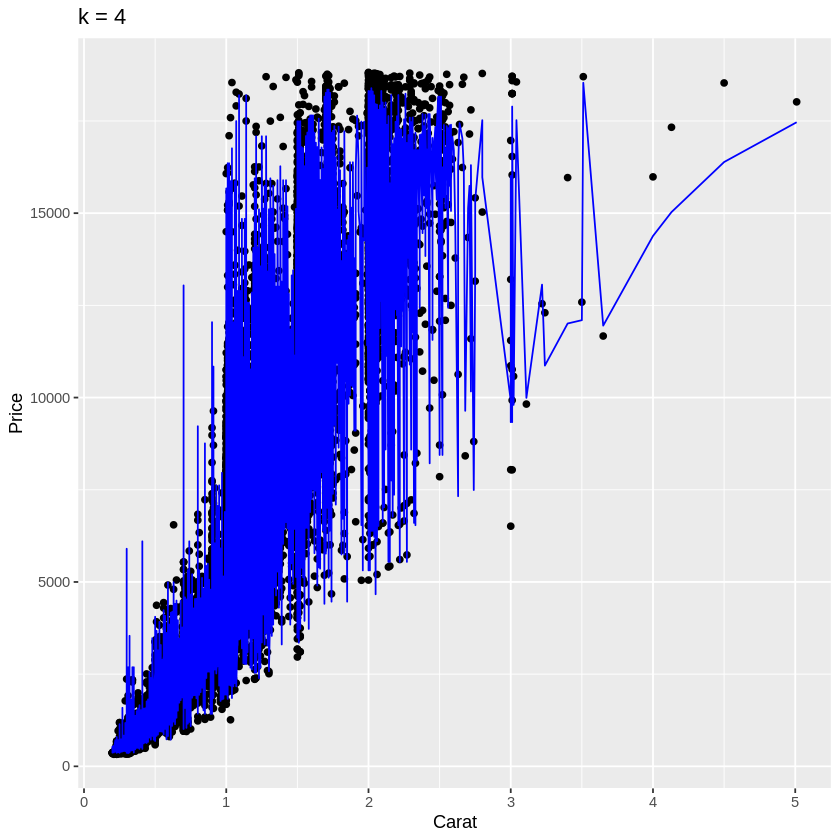

In [10]:
options(repr.plot.width = 7, repr.plot.height = 7)

# your code here
diamonds_preds <- diamonds_best_fit %>% 
    predict(diamonds_train) %>% 
    bind_cols(diamonds_train)

diamonds_plot <- ggplot(diamonds_train, aes(x = carat, y = price))+
    geom_point() +
    geom_line(data = diamonds_preds, 
            mapping = aes(x = carat, y = .pred), 
            color = "blue") +
    labs(x = "Carat", y = "Price", title = "k = 4")

diamonds_plot